# Машинное обучение, ФКН ВШЭ

# Практическое задание 11. Несбалансированные задачи

## Общая информация
Дата выдачи: 23.04.2024

Мягкий дедлайн: 13.05.2024 23:59 MSK

Жесткий дедлайн: 18.05.2024 23:59 MSK

## Оценивание и штрафы

Каждая из задач имеет определенную «стоимость» (указана в скобках около задачи). Максимально допустимая оценка за работу — 10 баллов.

Сдавать задание после указанного срока сдачи нельзя. При выставлении неполного балла за задание в связи с наличием ошибок на усмотрение проверяющего предусмотрена возможность исправить работу на указанных в ответном письме условиях.

Задание выполняется самостоятельно. «Похожие» решения считаются плагиатом и все задействованные студенты (в том числе те, у кого списали) не могут получить за него больше 0 баллов (подробнее о плагиате см. на странице курса). Если вы нашли решение какого-то из заданий (или его часть) в открытом источнике, необходимо указать ссылку на этот источник в отдельном блоке в конце вашей работы (скорее всего вы будете не единственным, кто это нашел, поэтому чтобы исключить подозрение в плагиате, необходима ссылка на источник).

Неэффективная реализация кода может негативно отразиться на оценке.

## Формат сдачи
Задания сдаются через систему anytask. Посылка должна содержать:
* Ноутбук homework-practice-xx-Username.ipynb

Username — ваша фамилия и имя на латинице именно в таком порядке

## О задании

В этом задании мы разберем основные техники работы в задачах, где один из классов занимает существенно меньшую долю выборки, чем остальные. Для простоты мы обойдемся бинарной задачей, тем не менее, во многом данные методы можно перенести и на задачи с б**о**льшим числом классов. Кроме того, вы получите очередной бесценный опыт исследования случайной библиотеки случайных индусов с нуля.

In [237]:
import numpy as np
import pandas as pd
pd.set_option('display.max_rows', 100)
pd.set_option('display.max_columns', 100)

import matplotlib.pyplot as plt
import seaborn as sns
sns.set(style='whitegrid')

from tqdm.auto import tqdm

**Задание -1 (1 балл)**. EDA

В качестве данных для нашей работы возьмем выложенный на kaggle датасет транзакций, в котором нужно выискивать мошеннические проводки: [клик](https://www.kaggle.com/mlg-ulb/creditcardfraud). Данная задача по определению подходит под несбалансированную, что можно сказать даже без наличия каких-либо данных (понятно, что среди всех транзакций клиентов очень малая часть будет мошеннической).

Загрузим данные, проведем некоторые классические манипуляции.

In [238]:
df = pd.read_csv('creditcard.csv')

In [239]:
df

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,V11,V12,V13,V14,V15,V16,V17,V18,V19,V20,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,0.090794,-0.551600,-0.617801,-0.991390,-0.311169,1.468177,-0.470401,0.207971,0.025791,0.403993,0.251412,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,-0.166974,1.612727,1.065235,0.489095,-0.143772,0.635558,0.463917,-0.114805,-0.183361,-0.145783,-0.069083,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,0.207643,0.624501,0.066084,0.717293,-0.165946,2.345865,-2.890083,1.109969,-0.121359,-2.261857,0.524980,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,-0.054952,-0.226487,0.178228,0.507757,-0.287924,-0.631418,-1.059647,-0.684093,1.965775,-1.232622,-0.208038,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,0.753074,-0.822843,0.538196,1.345852,-1.119670,0.175121,-0.451449,-0.237033,-0.038195,0.803487,0.408542,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
284802,172786.0,-11.881118,10.071785,-9.834783,-2.066656,-5.364473,-2.606837,-4.918215,7.305334,1.914428,4.356170,-1.593105,2.711941,-0.689256,4.626942,-0.924459,1.107641,1.991691,0.510632,-0.682920,1.475829,0.213454,0.111864,1.014480,-0.509348,1.436807,0.250034,0.943651,0.823731,0.77,0
284803,172787.0,-0.732789,-0.055080,2.035030,-0.738589,0.868229,1.058415,0.024330,0.294869,0.584800,-0.975926,-0.150189,0.915802,1.214756,-0.675143,1.164931,-0.711757,-0.025693,-1.221179,-1.545556,0.059616,0.214205,0.924384,0.012463,-1.016226,-0.606624,-0.395255,0.068472,-0.053527,24.79,0
284804,172788.0,1.919565,-0.301254,-3.249640,-0.557828,2.630515,3.031260,-0.296827,0.708417,0.432454,-0.484782,0.411614,0.063119,-0.183699,-0.510602,1.329284,0.140716,0.313502,0.395652,-0.577252,0.001396,0.232045,0.578229,-0.037501,0.640134,0.265745,-0.087371,0.004455,-0.026561,67.88,0
284805,172788.0,-0.240440,0.530483,0.702510,0.689799,-0.377961,0.623708,-0.686180,0.679145,0.392087,-0.399126,-1.933849,-0.962886,-1.042082,0.449624,1.962563,-0.608577,0.509928,1.113981,2.897849,0.127434,0.265245,0.800049,-0.163298,0.123205,-0.569159,0.546668,0.108821,0.104533,10.00,0


Наши данные были анонимизированы. Мы имеем 30 признаков, из которых 28 - это результаты PCA-преобразования на исходном датасете. Еще 2 признака представляют собой время в секундах, прошедшее с момента первой транзакции в датасете, и размер транзакции. Скажите, какова доля положительных объектов в выборке?

In [240]:
df[df['Class'] == 1].shape[0] / df.shape[0]

0.001727485630620034

Начнем с обработки времени. Секунды сами по себе не несут большой информации о зависимостях в данных, попробуйте по ним создать признаки "час" (от 0 до 23) и "день" (от 0 до ...) в аналогичной манере (принимая первый объект выборки за начальную точку). Сколько дней покрывают данные?

In [241]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
df[['V1', 'V2', 'V3', 'V4', 'V5', 'V6', 'V7', 'V8', 'V9', 'V10', 'V11', 'V12', 'V13', 'V14', 'V15', 'V16', 'V17', 'V18', 'V19', 'V20', 'V21', 'V22', 'V23', 'V24', 'V25', 'V26', 'V27', 'V28']] = scaler.fit_transform(df[['V1', 'V2', 'V3', 'V4', 'V5', 'V6', 'V7', 'V8', 'V9', 'V10', 'V11', 'V12', 'V13', 'V14', 'V15', 'V16', 'V17', 'V18', 'V19', 'V20', 'V21', 'V22', 'V23', 'V24', 'V25', 'V26', 'V27', 'V28']])

In [243]:
df['Hour'] = (df['Time'] // 3600 % 24).astype(int)
df['Day'] = (df['Time'] // (3600 * 24)).astype(int)

In [244]:
df['Day'].unique()

array([0, 1])

Постройте следующие графики:

1. Распределение числа транзакций по каждому часу (line-plot).
2. Распределение доли мошеннических транзакций по каждому часу (line-plot)
3. То же самое для дней (здесь можно использовать bar-plot, так как дней должно быть немного).

Какие выводы можно сделать из графиков? На ваш взгляд, как можно связать полученные нами часы с реальными часами в сутках?

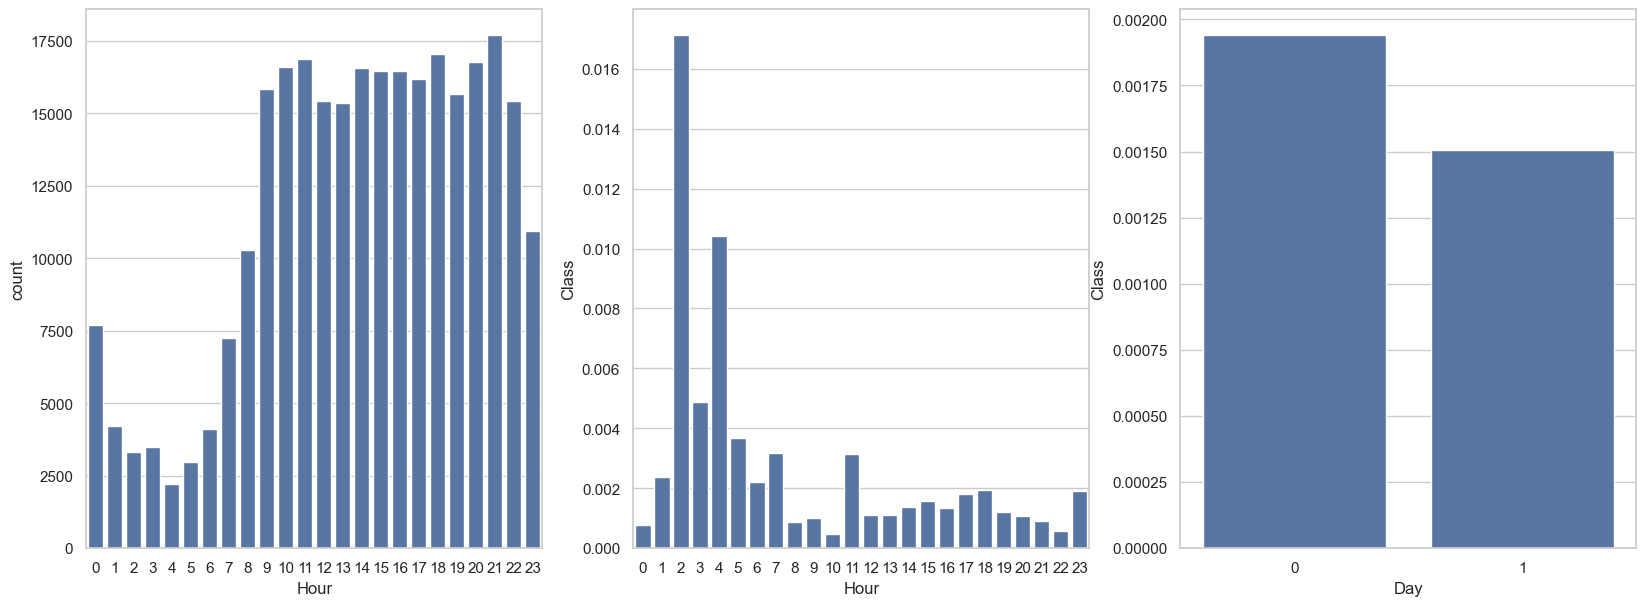

In [245]:
fig, ax = plt.subplots(1, 3, figsize=(20, 7))
sns.countplot(df, x='Hour', ax=ax[0])
sns.barplot(df, x='Hour', y='Class', ax=ax[1], errorbar=None)
sns.barplot(df, x='Day', y='Class', ax=ax[2], errorbar=None)
plt.show()

Город засыпает --  просыпаются мошенники

С анонимизированными признаками вряд ли можно придумать что-то интересное. Попробуйте (например, с помощью корреляции?) выбрать несколько наиболее важных признаков и поглядеть на различия в их распределении для разных классов.

In [246]:
np.abs(df.corr()['Class']).sort_values(ascending=False)[:5]

Class    1.000000
V17      0.326481
V14      0.302544
V12      0.260593
V10      0.216883
Name: Class, dtype: float64

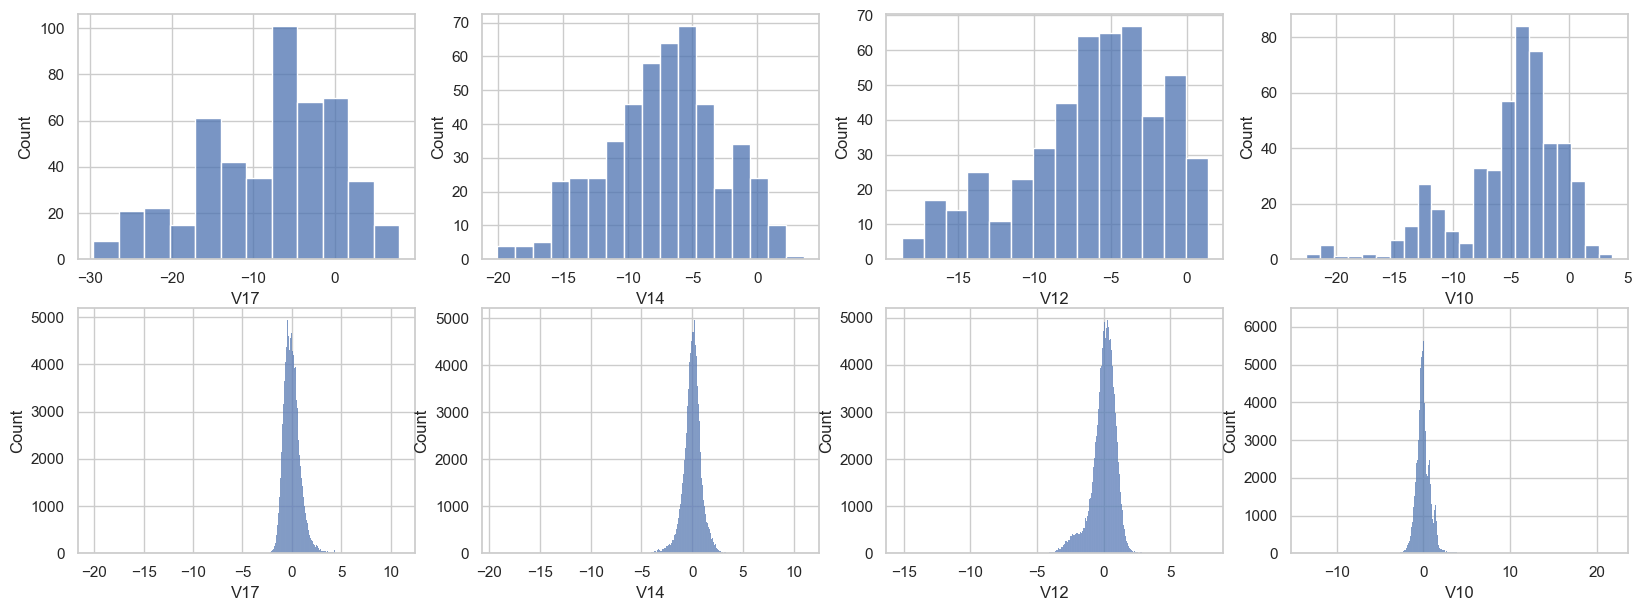

In [248]:
fig, ax = plt.subplots(2, 4, figsize=(20, 7))
sns.histplot(df[df['Class'] == 1], x='V17', ax=ax[0,0])
sns.histplot(df[df['Class'] == 1], x='V14', ax=ax[0,1])
sns.histplot(df[df['Class'] == 1], x='V12', ax=ax[0,2])
sns.histplot(df[df['Class'] == 1], x='V10', ax=ax[0,3])
sns.histplot(df[df['Class'] == 0], x='V17', ax=ax[1,0])
sns.histplot(df[df['Class'] == 0], x='V14', ax=ax[1,1])
sns.histplot(df[df['Class'] == 0], x='V12', ax=ax[1,2])
sns.histplot(df[df['Class'] == 0], x='V10', ax=ax[1,3])
plt.show()

Теперь давайте разделим данные. Отделите хронологически последние 20% транзакций и поделите их пополам (также хронологически, т.е. без перемешивания) на валидационные и тестовые. Это разбиение не совсем корректно (как можно было заметить, мошеннические транзакции имеют разное распределение во времени - по-хорошему, нам стоило бы выделить целые сутки записей как под валидацию, так и под тест), тем не менее, мы не сможем получить больше данных для адекватного контроля, поэтому обойдемся этим. 

In [249]:
train = df.iloc[[i for i in range(int(df.shape[0] * 0.8))]]
val = df.iloc[[i for i in range(int(df.shape[0] * 0.8), int(df.shape[0] * 0.9))]]
test = df.iloc[[i for i in range(int(df.shape[0] * 0.9), df.shape[0])]]

X_train, y_train = train.drop(columns='Class').copy(), train['Class'].copy()
X_val, y_val = val.drop(columns='Class').copy(), val['Class'].copy()
X_test, y_test = test.drop(columns='Class').copy(), test['Class'].copy()


# Часть 1. Несбалансированная классификация.

**Задание 0. (1 балл)**: перед началом работы давайте поговорим о том, как мы будем оценивать качество. Классические метрики для качества классификации чаще всего "ломаются" на задачах с сильным перекосом. Чему будет равно значение accuracy для наивного предсказания (= мажорный класс для каждого объекта)? (можете не отвечать, просто подумайте)

Из курса МО-1 вам уже известно, что мы можем использовать в таких задачах `AUC-PR` и получать адекватные показатели. Можно сказать, что `AUC-PR` представляет собой матожидание `precision` по распределению, заданному выигрышем в `recall` при смене порога. 

Тем не менее, существуют и другие, не менее интересные метрики. Одной из таких метрик является коэффициент Каппа Коэна, представляющий собой нормализованную `accuracy`:

$$\kappa = \frac{p_o - p_e}{1 - p_e}$$

Данная метрика служит в качестве меры согласованности между двумя независимыми предсказателями, но ничего не знает про "верные" и "предсказанные" метки (в отличие от многих других метрик машинного обучения). Здесь $p_o$ - доля согласованных предсказаний, а $p_e$ - доля согласованных предсказаний, которая могла бы получиться при случайных ответах предсказателей. В нашем случае это работает так:

• В качестве $p_o$ берем accuracy

• В качестве $p_e$ примем следующую величину - вероятность случайного соглашения позитивных ответов (произведение долей позитивных ответов в обоих предсказаниях) плюс вероятность случайного соглашения негативных ответов (произведение долей негативных ответов в обоих предсказаниях)

Метрика принимает значения от -1 до 1, где 1 - полная согласованность, 0 - согласованность на уровне рандома, -1 - совсем плохо. Как уже говорилось, метрика не различает "верные" и "предсказанные" метки, поэтому является симметричной (можете использовать это для отладки):

Еще одной метрикой в такой задаче служит коэффициент корреляции Мэтьюза, выражающийся в терминах матрицы ошибок следующим образом:

$$\text{MCC} = \frac{TP\times TN - FP \times FN}{\sqrt{(TP+FP)(TP+FN)(TN+FP)(TN+FN)}}$$ 

Метрика принимает значения от -1 до 1, интерпретируемые аналогичным образом. 

Обратите внимание, что эти метрики вычисляются на бинаризованных предсказаниях, поэтому может иметь смысл дополнительная настройка порога бинаризации.

Давайте проверим, что наши метрики действительно подходят под задачу. Вычислите их значения для наивного предсказания (aka мажорный класс для всех объектов):

In [398]:
from sklearn.metrics import accuracy_score, confusion_matrix, auc, precision_recall_curve

def auc_pr(y_true, y_pred):
    precision, recall, _ = precision_recall_curve(y_true, y_pred)
    return auc(recall, precision)

def kappa(y_true, y_pred):
    p_0 = accuracy_score(y_true, y_pred)
    p_e = y_pred.mean() * y_true.mean() + (1 - y_pred).mean() * (1 - y_true).mean()
    return (p_0 - p_e) / (1 - p_e)

def mcc(y_true, y_pred):
    tn, fp, fn, tp = confusion_matrix(y_true, y_pred).ravel()
    return (tp * tn - fp * fn) / np.sqrt((tp + fp) * (tp + fn) * (tn + fp) * (tn + fn))

In [251]:
y_pred_train = np.ones_like(y_train) * np.round(y_train.mean())
y_pred_val = np.ones_like(y_val) * np.round(y_train.mean())
y_pred_test = np.ones_like(y_test) * np.round(y_train.mean())

print(f'auc-pr for train: {auc_pr(y_train, y_pred_train)}')
print(f'auc-pr for val: {auc_pr(y_val, y_pred_val)}')
print(f'auc-pr for test: {auc_pr(y_test, y_pred_test)}')

print(f'kappa for train: {kappa(y_train, y_pred_train)}')
print(f'kappa for val: {kappa(y_val, y_pred_val)}')
print(f'kappa for test: {kappa(y_test, y_pred_test)}')

print(f'mcc for train: {mcc(y_train, y_pred_train)}')
print(f'mcc for val: {mcc(y_val, y_pred_val)}')
print(f'mcc for test: {mcc(y_test, y_pred_test)}')

auc-pr for train: 0.4990849042111962
auc-pr for val: 0.4990695551420245
auc-pr for test: 0.49961377760612335
kappa for train: 0.0
kappa for val: 0.0
kappa for test: 0.0
mcc for train: nan
mcc for val: nan
mcc for test: nan


/var/folders/n6/f0pmc36s6nbcbbqtyldp_frm0000gn/T/ipykernel_54934/3969174468.py:14: RuntimeWarning: invalid value encountered in scalar divide
  return (tp * tn - fp * fn) / np.sqrt((tp + fp) * (tp + fn) * (tn + fp) * (tn + fn))
/var/folders/n6/f0pmc36s6nbcbbqtyldp_frm0000gn/T/ipykernel_54934/3969174468.py:14: RuntimeWarning: invalid value encountered in scalar divide
  return (tp * tn - fp * fn) / np.sqrt((tp + fp) * (tp + fn) * (tn + fp) * (tn + fn))
/var/folders/n6/f0pmc36s6nbcbbqtyldp_frm0000gn/T/ipykernel_54934/3969174468.py:14: RuntimeWarning: invalid value encountered in scalar divide
  return (tp * tn - fp * fn) / np.sqrt((tp + fp) * (tp + fn) * (tn + fp) * (tn + fn))


Давайте запустим бейзлайн-решение для нашей задачи. С чего же начнем? Возьмите `catboost` и обучите его классификатор на наших данных (используйте все признаки). Вычислите значения всех метрик на тестовой части, для контроля переобучения используйте валидационную (здесь и далее везде, где фигурирует `catboost`). 

In [252]:
from catboost import CatBoostClassifier
import optuna

def objective(trial):
    params = {
        'n_estimators' : trial.suggest_int('n_estimators', 1, 100),
        'learning_rate' : trial.suggest_float('learning_rate', 0, 1)
    }

    boosting = CatBoostClassifier(**params, random_seed=0,  verbose=0)
    boosting.fit(X_train, y_train)
    return boosting.score(X_val, y_val)

study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=100)

boosting = CatBoostClassifier(**study.best_params, random_seed=0, verbose=0).fit(X_train, y_train)
y_pred = boosting.predict(X_test)

[I 2024-05-03 09:14:34,608] A new study created in memory with name: no-name-a33e5335-4d82-46c4-94d9-de65b83db40a
[I 2024-05-03 09:14:35,127] Trial 0 finished with value: 0.9988764439450862 and parameters: {'n_estimators': 31, 'learning_rate': 0.016036719209257533}. Best is trial 0 with value: 0.9988764439450862.
[I 2024-05-03 09:14:35,270] Trial 1 finished with value: 0.9992977774656788 and parameters: {'n_estimators': 6, 'learning_rate': 0.8048251661015754}. Best is trial 1 with value: 0.9992977774656788.
[I 2024-05-03 09:14:36,260] Trial 2 finished with value: 0.9995435553526912 and parameters: {'n_estimators': 82, 'learning_rate': 0.068457178027437}. Best is trial 2 with value: 0.9995435553526912.
[I 2024-05-03 09:14:37,417] Trial 3 finished with value: 0.9993679997191109 and parameters: {'n_estimators': 100, 'learning_rate': 0.9555462761168676}. Best is trial 2 with value: 0.9995435553526912.
[I 2024-05-03 09:14:38,610] Trial 4 finished with value: 0.9994382219725431 and parameter

In [253]:
print(f'auc-pr: {auc_pr(y_test, y_pred)}')
print(f'kappa: {kappa(y_test, y_pred)}')
print(f'mcc: {mcc(y_test, y_pred)}')

auc-pr: 0.677193041913485
kappa: 0.6664420442680108
mcc: 0.6719950755424033


Если вы все сделали правильно, у вас должны были получиться значения в районе 0.7.

**Задание 1. (1 балл)**. Многие реализации методов предлагают встроенные способы для борьбы с нашей проблемой. Самое часто встречающееся решение - просто добавить вес в функции потерь для минорного класса (таким образом, ошибка на объекте минорного класса будет весить больше, чем для мажорного). В `catboost` это также реализовано, причем для бинарной задачи это можно сделать целыми двумя способами (можете выбрать любой, на свой вкус, автор задания предпочитает отдельный скейлинг для минорного класса). Чаще всего в качестве веса берется отношение числа объектов мажорного класса к числу минорного. Попробуйте обучить модель с таким скалированием и сравните метрики на тестовой части с бейзлайном.

In [254]:
from catboost import CatBoostClassifier
import optuna

def objective(trial):
    params = {
        'n_estimators' : trial.suggest_int('n_estimators', 1, 100),
        'learning_rate' : trial.suggest_float('learning_rate', 0, 1)
    }

    boosting = CatBoostClassifier(**params, verbose=0, scale_pos_weight=y_train.shape[0] / np.sum(y_train==1) - 1, random_seed=0)
    boosting.fit(X_train, y_train)
    return boosting.score(X_val, y_val)

study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=100)

boosting = CatBoostClassifier(**study.best_params, verbose=0, scale_pos_weight=y_train.shape[0] / np.sum(y_train==1) - 1, random_seed=0).fit(X_train, y_train)
y_pred = boosting.predict(X_test)

[I 2024-05-03 09:17:06,127] A new study created in memory with name: no-name-286ee5a8-71e3-4ae7-a948-1c6358b9be63
[I 2024-05-03 09:17:07,049] Trial 0 finished with value: 0.9962079983146659 and parameters: {'n_estimators': 60, 'learning_rate': 0.07346055247714711}. Best is trial 0 with value: 0.9962079983146659.
[I 2024-05-03 09:17:07,575] Trial 1 finished with value: 0.9989817773252344 and parameters: {'n_estimators': 37, 'learning_rate': 0.31420040185912157}. Best is trial 1 with value: 0.9989817773252344.
[I 2024-05-03 09:17:07,886] Trial 2 finished with value: 0.9942066640918507 and parameters: {'n_estimators': 20, 'learning_rate': 0.03872844491741856}. Best is trial 1 with value: 0.9989817773252344.
[I 2024-05-03 09:17:08,696] Trial 3 finished with value: 0.9991924440855307 and parameters: {'n_estimators': 58, 'learning_rate': 0.47884368198574623}. Best is trial 3 with value: 0.9991924440855307.
[I 2024-05-03 09:17:09,806] Trial 4 finished with value: 0.9993328885923949 and parame

In [255]:
print(f'auc-pr: {auc_pr(y_test, y_pred)}')
print(f'kappa: {kappa(y_test, y_pred)}')
print(f'mcc: {mcc(y_test, y_pred)}')

auc-pr: 0.7107953391852803
kappa: 0.7108828212297992
mcc: 0.7110586906187203


Поскольку данный вес будет являться гиперпараметром метода, было бы опрометчиво остановиться на одном значении (тем более, с большой вероятностью у вас все сломалось). Запустите перебор для этого гиперпараметра на валидационной выборке (используйте `PR-AUC`), подберите оптимальный порог бинаризации для $\kappa$ или $\text{MCC}$. Для лучшего найденного веса и порога вычислите все метрики на тестовой части. 

При этом можете также проверить отдельное скалирование в большую сторону для мажорного класса (т.е. веса минорного сделать меньше 1) и экстремальные скалирования (т.е. веса минорного больше, чем в начале этого задания). Какой вес получился оптимальным?

In [256]:
from catboost import CatBoostClassifier
import optuna

def objective(trial):
    params = {
        'n_estimators' : trial.suggest_int('n_estimators', 1, 100),
        'learning_rate' : trial.suggest_float('learning_rate', 0, 1),
        'scale_pos_weight' : trial.suggest_int('scale_pos_weight', 1, 30)
    }
    boosting = CatBoostClassifier(**params, random_seed=0, verbose=0).fit(X_train, y_train)
    y_pred = boosting.predict(X_val)
    return auc_pr(y_val, y_pred)

study_scale = optuna.create_study(direction='maximize')
study_scale.optimize(objective, n_trials=100)

[I 2024-05-03 09:18:56,637] A new study created in memory with name: no-name-a0f552eb-5aa2-4627-8fbc-da326c81794b
[I 2024-05-03 09:18:57,521] Trial 0 finished with value: 0.8538094164729482 and parameters: {'n_estimators': 65, 'learning_rate': 0.5179280872420496, 'scale_pos_weight': 7}. Best is trial 0 with value: 0.8538094164729482.
[I 2024-05-03 09:18:58,077] Trial 1 finished with value: 0.8419191725705092 and parameters: {'n_estimators': 45, 'learning_rate': 0.3695887432385828, 'scale_pos_weight': 2}. Best is trial 0 with value: 0.8538094164729482.
[I 2024-05-03 09:18:58,303] Trial 2 finished with value: 0.8447639989965207 and parameters: {'n_estimators': 7, 'learning_rate': 0.30192512835247587, 'scale_pos_weight': 16}. Best is trial 0 with value: 0.8538094164729482.
[I 2024-05-03 09:18:59,256] Trial 3 finished with value: 0.8302712777191957 and parameters: {'n_estimators': 79, 'learning_rate': 0.601783720449274, 'scale_pos_weight': 28}. Best is trial 0 with value: 0.853809416472948

In [257]:
from catboost import CatBoostClassifier
import optuna

def objective(trial):
    threshold = trial.suggest_float('threshold', 0, 1)
    boosting = CatBoostClassifier(**study_scale.best_params, random_seed=0, verbose=0).fit(X_train, y_train)
    boosting.set_probability_threshold(threshold)
    y_pred = boosting.predict(X_val)
    return kappa(y_val, y_pred)

study_thr = optuna.create_study(direction='maximize')
study_thr.optimize(objective, n_trials=100)

[I 2024-05-03 09:20:31,767] A new study created in memory with name: no-name-18ef604f-c429-42b7-bdb8-71df04ccfdb3
[I 2024-05-03 09:20:32,824] Trial 0 finished with value: 0.8840196901944707 and parameters: {'threshold': 0.5785023906161049}. Best is trial 0 with value: 0.8840196901944707.
[I 2024-05-03 09:20:33,809] Trial 1 finished with value: 0.7327780478494031 and parameters: {'threshold': 0.0929439147397888}. Best is trial 0 with value: 0.8840196901944707.
[I 2024-05-03 09:20:34,847] Trial 2 finished with value: 0.8840196901944707 and parameters: {'threshold': 0.7309719231376005}. Best is trial 0 with value: 0.8840196901944707.
[I 2024-05-03 09:20:35,891] Trial 3 finished with value: 0.7221154718924785 and parameters: {'threshold': 0.09574891301481747}. Best is trial 0 with value: 0.8840196901944707.
[I 2024-05-03 09:20:36,884] Trial 4 finished with value: 0.8840196901944707 and parameters: {'threshold': 0.6907900125692716}. Best is trial 0 with value: 0.8840196901944707.
[I 2024-05

In [258]:
boosting = CatBoostClassifier(**study_scale.best_params, random_seed=0, verbose=0).fit(X_train, y_train)
boosting.set_probability_threshold(study_thr.best_params['threshold'])
y_pred = boosting.predict(X_test)
print(f'auc-pr: {auc_pr(y_test, y_pred)}')
print(f'kappa: {kappa(y_test, y_pred)}')
print(f'mcc: {mcc(y_test, y_pred)}')

auc-pr: 0.7152595350648437
kappa: 0.7140753704859292
mcc: 0.71488755582656


**Задание 2. (1 балл)**. На самом деле, то, что мы сейчас делали, очень схоже с другой распространенной техникой - оверсэмплингом. Фактически, мы можем продублировать все объекты минорного класса и получить тот же эффект, какой был бы при использовании веса, равного 2. Тем не менее, такой подход - это лишь малая часть того, что мы можем проделать с целью повысить число объектов минорного класса. 

Для продолжения работы установим библиотеку [imbalanced-learn](https://imbalanced-learn.org/stable/):

In [20]:
# !pip3 install imbalanced-learn

Первый метод, которым мы воспользуемся, называется SMOTE (его вы уже разбирали на лекции). Кратко напомним суть: мы выбираем случайного кандидата среди $k$ ближайших соседей объекта минорного класса, затем берем точку на отрезке между двумя объектами (т.е. выпуклую комбинацию со случайными коэффициентами) и добавляем в выборку. 

In [21]:
from imblearn.over_sampling import SMOTE

Используйте SMOTE для ресэмплинга обучающей выборки, на новой выборке обучите модель (вес положительных объектов скалировать не нужно). Замерьте качество на тестовой выборке (**важно!** не преобразовывайте валидационную и тестовую выборку никак - мы не хотим отслеживать качество на объектах, которых в реальности не существует). Сравните полное выравнивание выборки с частичным (т.е. таким, что баланс классов улучшается, но не достигает равенства - скажем, 1:2 и 1:10).

In [259]:
smote = SMOTE(random_state=0)
X_train_smote, y_train_smote = smote.fit_resample(X_train, y_train)

In [260]:
def objective(trial):
    params = {
        'n_estimators' : trial.suggest_int('n_estimators', 1, 100),
        'learning_rate' : trial.suggest_float('learning_rate', 0, 1)
    }
    threshold = trial.suggest_float('threshold', 0, 1)
    boosting = CatBoostClassifier(**params, random_seed=0, verbose=0).fit(X_train_smote, y_train_smote)
    boosting.set_probability_threshold(threshold)
    y_pred = boosting.predict(X_val)
    return auc_pr(y_val, y_pred)

study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=100)

[I 2024-05-03 09:23:16,958] A new study created in memory with name: no-name-bbd4a534-2682-4596-b9af-979fd4d99a76


[I 2024-05-03 09:23:18,875] Trial 0 finished with value: 0.6989064626622835 and parameters: {'n_estimators': 100, 'learning_rate': 0.8223705524999604, 'threshold': 0.3537471467019778}. Best is trial 0 with value: 0.6989064626622835.
[I 2024-05-03 09:23:20,369] Trial 1 finished with value: 0.7719346827047228 and parameters: {'n_estimators': 74, 'learning_rate': 0.9665075354369023, 'threshold': 0.498098618438102}. Best is trial 1 with value: 0.7719346827047228.
[I 2024-05-03 09:23:22,435] Trial 2 finished with value: 0.7005268452591493 and parameters: {'n_estimators': 77, 'learning_rate': 0.3970789212711362, 'threshold': 0.128106396955319}. Best is trial 1 with value: 0.7719346827047228.
[I 2024-05-03 09:23:23,136] Trial 3 finished with value: 0.6630111878544331 and parameters: {'n_estimators': 23, 'learning_rate': 0.543760625341128, 'threshold': 0.4568667222654539}. Best is trial 1 with value: 0.7719346827047228.
[I 2024-05-03 09:23:24,310] Trial 4 finished with value: 0.666170165227339

In [261]:
boosting = CatBoostClassifier(n_estimators=study.best_params['n_estimators'], learning_rate=study.best_params['learning_rate'], random_seed=0, verbose=0).fit(X_train_smote, y_train_smote)
boosting.set_probability_threshold(study.best_params['threshold'])
y_pred = boosting.predict(X_test)
print(f'auc-pr: {auc_pr(y_test, y_pred)}')
print(f'kappa: {kappa(y_test, y_pred)}')
print(f'mcc: {mcc(y_test, y_pred)}')

auc-pr: 0.7439216331811395
kappa: 0.743992894025702
mcc: 0.7441944677557768


In [262]:
smote = SMOTE(random_state=0, sampling_strategy=1/2)
X_train_smote, y_train_smote = smote.fit_resample(X_train, y_train)
def objective(trial):
    params = {
        'n_estimators' : trial.suggest_int('n_estimators', 1, 100),
        'learning_rate' : trial.suggest_float('learning_rate', 0, 1)
    }
    threshold = trial.suggest_float('threshold', 0, 1)
    boosting = CatBoostClassifier(**params, random_seed=0, verbose=0).fit(X_train_smote, y_train_smote)
    boosting.set_probability_threshold(threshold)
    y_pred = boosting.predict(X_val)
    return auc_pr(y_val, y_pred)

study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=100)
boosting = CatBoostClassifier(n_estimators=study.best_params['n_estimators'], learning_rate=study.best_params['learning_rate'], random_seed=0, verbose=0).fit(X_train_smote, y_train_smote)
boosting.set_probability_threshold(study.best_params['threshold'])
y_pred = boosting.predict(X_test)

[I 2024-05-03 09:26:06,604] A new study created in memory with name: no-name-48107a4b-25b1-4d5d-b57f-807f05f0be52
[I 2024-05-03 09:26:06,984] Trial 0 finished with value: 0.7067919446845705 and parameters: {'n_estimators': 15, 'learning_rate': 0.7500962474982324, 'threshold': 0.6748035905133182}. Best is trial 0 with value: 0.7067919446845705.
[I 2024-05-03 09:26:07,480] Trial 1 finished with value: 0.5014371077383246 and parameters: {'n_estimators': 27, 'learning_rate': 0.017156834433667, 'threshold': 0.38673333288261313}. Best is trial 0 with value: 0.7067919446845705.
[I 2024-05-03 09:26:08,117] Trial 2 finished with value: 0.8231300651467555 and parameters: {'n_estimators': 32, 'learning_rate': 0.6344105580083598, 'threshold': 0.7840087292620354}. Best is trial 2 with value: 0.8231300651467555.
[I 2024-05-03 09:26:08,363] Trial 3 finished with value: 0.6945586365753269 and parameters: {'n_estimators': 9, 'learning_rate': 0.5843034824585879, 'threshold': 0.8352538339100244}. Best is

In [263]:
print(f'auc-pr: {auc_pr(y_test, y_pred)}')
print(f'kappa: {kappa(y_test, y_pred)}')
print(f'mcc: {mcc(y_test, y_pred)}')

auc-pr: 0.807413696673203
kappa: 0.7998608632102646
mcc: 0.8038960655235946


In [27]:
smote = SMOTE(random_state=0, sampling_strategy=1/10)
X_train_smote, y_train_smote = smote.fit_resample(X_train, y_train)
def objective(trial):
    params = {
        'n_estimators' : trial.suggest_int('n_estimators', 1, 100),
        'learning_rate' : trial.suggest_float('learning_rate', 0, 1)
    }
    threshold = trial.suggest_float('threshold', 0, 1)
    boosting = CatBoostClassifier(**params, random_seed=0, verbose=0).fit(X_train_smote, y_train_smote)
    boosting.set_probability_threshold(threshold)
    y_pred = boosting.predict(X_val)
    return auc_pr(y_val, y_pred)

study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=100)
boosting = CatBoostClassifier(n_estimators=study.best_params['n_estimators'], learning_rate=study.best_params['learning_rate'], random_seed=0, verbose=0).fit(X_train_smote, y_train_smote)
boosting.set_probability_threshold(study.best_params['threshold'])
y_pred = boosting.predict(X_test)

[I 2024-05-02 22:25:42,358] A new study created in memory with name: no-name-5f8641de-d2a4-4614-80ab-bfe6beedfe3c
[I 2024-05-02 22:25:43,134] Trial 0 finished with value: 0.8413671472136248 and parameters: {'n_estimators': 60, 'learning_rate': 0.05060546735031868, 'threshold': 0.845540817016845}. Best is trial 0 with value: 0.8413671472136248.
[I 2024-05-02 22:25:44,277] Trial 1 finished with value: 0.7079914723962225 and parameters: {'n_estimators': 97, 'learning_rate': 0.38620567984569354, 'threshold': 0.1121205195434215}. Best is trial 0 with value: 0.8413671472136248.
[I 2024-05-02 22:25:44,685] Trial 2 finished with value: 0.6752962118816748 and parameters: {'n_estimators': 28, 'learning_rate': 0.42134507955418243, 'threshold': 0.23736129020633145}. Best is trial 0 with value: 0.8413671472136248.
[I 2024-05-02 22:25:44,977] Trial 3 finished with value: 0.571618202772438 and parameters: {'n_estimators': 19, 'learning_rate': 0.5493226699253091, 'threshold': 0.1739828474030063}. Best

In [28]:
print(f'auc-pr: {auc_pr(y_test, y_pred)}')
print(f'kappa: {kappa(y_test, y_pred)}')
print(f'mcc: {mcc(y_test, y_pred)}')

auc-pr: 0.8335574875228762
kappa: 0.8203918699904673
mcc: 0.8272276657666917


**Бонус (1.5 балла)**. Для vanilla SMOTE существуют некоторые модификации, часть из которых была реализована в библиотеке imblearn. Во время лекций/семинаров эти модификации не рассматривались, тем не менее, мы все равно их исследуем.

Найдите статьи о следующих методах и попробуйте вкратце сформулировать, в чем их основная идея (сделайте так, чтобы человек, знакомый с машинным обучением в целом, но не слышавший конкретно про это смог понять).

Будем считать, что это человек знает про SMOTE:

1. BorderlineSMOTE - Для каждого объекта минорного класса ищутся m ближайших соседей; пусть $m'$ -- число ближайших соседей, которые принадлежат мажорному классу; далее идёт работа только с объектами минорного класс, у которых число соседей мажорного класса $m'\in[m/2, m)$ (эти объекты называются DANGER); далее для каждой "опасной" точки находят k ближайших соседей (они должны обязательно принадлежать минорному класу), оставляют s и генерируют новый объект как выпуклую комбинацию соседа и текущей "опасной" точки.

2. SVM-SMOTE - Тут находят опорные вектора для минорного класса (по сути те же borderline samples) с помощью SVM; далее для каждого такого объекта находят ближайших соседей из минорного класса и считают выпуклую комбинацию, если количество ближайших соседей мажорного класса больше половину (как в прошлом методе), или разницу со знаком минус иначе.

3. K-Means-SMOTE - Запускаем KMeans на выборке, для каждого кластера считаем отношение количества минорных объектов к количеству мажорных и оставляем только те кластера, для которых это отношение больше некоторого порога; далее вычисляется что-то вроде плотности для каждого из кластеров, чтобы понять, куда лучше пихать сгенерированные точки; далее для каждого кластера запускается обычный SMOTE, который генерирует нужное для этого кластера количество точек.

4. ADASYN - Для каждого минорного объекта находятся K ближайших соседей и считается доля мажорных объектов среди этих соседей; дальше эти доли нормализуются, чтобы суммироваться в 1; далее для каждого минорного объекта генерируются новые объекты в числе пропорциональном доли мажорных объектов среди ближайший соседей; сэмплирование происходит, как и в SMOTE: берём рандомного ближайшего минорного соседа и считаем выпуклую комбинацию. Глобальная идея метода такова, что мы генерируем больше новых данных туда, где для минорного объекта больше мажорных соседей, и соответственно, меньше туда, где большое скопление минорных объектов.

Теперь попробуйте сравнить качество всех методов на наших данных.

In [600]:
from imblearn.over_sampling import BorderlineSMOTE
sampler = BorderlineSMOTE(random_state=0, sampling_strategy=1/10)
X_train_smote, y_train_smote = sampler.fit_resample(X_train, y_train)
def objective(trial):
    params = {
        'n_estimators' : trial.suggest_int('n_estimators', 1, 100),
        'learning_rate' : trial.suggest_float('learning_rate', 0, 1)
    }
    threshold = trial.suggest_float('threshold', 0, 1)
    boosting = CatBoostClassifier(**params, random_seed=0, verbose=0).fit(X_train_smote, y_train_smote)
    boosting.set_probability_threshold(threshold)
    y_pred = boosting.predict(X_val)
    return auc_pr(y_val, y_pred)

optuna.logging.set_verbosity(optuna.logging.WARNING)
study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=100, n_jobs=-1)
boosting = CatBoostClassifier(n_estimators=study.best_params['n_estimators'], learning_rate=study.best_params['learning_rate'], random_seed=0, verbose=0).fit(X_train_smote, y_train_smote)
boosting.set_probability_threshold(study.best_params['threshold'])
y_pred = boosting.predict(X_test)
print(f'auc-pr: {auc_pr(y_test, y_pred)}')
print(f'kappa: {kappa(y_test, y_pred)}')
print(f'mcc: {mcc(y_test, y_pred)}')

auc-pr: 0.7822084504408323
kappa: 0.7690752614163152
mcc: 0.7754834690252622


In [601]:
from imblearn.over_sampling import SVMSMOTE
sampler = SVMSMOTE(random_state=0, sampling_strategy=1/10, n_jobs=-1)
X_train_smote, y_train_smote = sampler.fit_resample(X_train, y_train)
def objective(trial):
    params = {
        'n_estimators' : trial.suggest_int('n_estimators', 1, 100),
        'learning_rate' : trial.suggest_float('learning_rate', 0, 1)
    }
    threshold = trial.suggest_float('threshold', 0, 1)
    boosting = CatBoostClassifier(**params, random_seed=0, verbose=0).fit(X_train_smote, y_train_smote)
    boosting.set_probability_threshold(threshold)
    y_pred = boosting.predict(X_val)
    return auc_pr(y_val, y_pred)

optuna.logging.set_verbosity(optuna.logging.WARNING)
study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=100, n_jobs=-1)
boosting = CatBoostClassifier(n_estimators=study.best_params['n_estimators'], learning_rate=study.best_params['learning_rate'], random_seed=0, verbose=0).fit(X_train_smote, y_train_smote)
boosting.set_probability_threshold(study.best_params['threshold'])
y_pred = boosting.predict(X_test)
print(f'auc-pr: {auc_pr(y_test, y_pred)}')
print(f'kappa: {kappa(y_test, y_pred)}')
print(f'mcc: {mcc(y_test, y_pred)}')

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/imblearn/over_sampling/_smote/filter.py:437: FutureWarning: The parameter `n_jobs` has been deprecated in 0.10 and will be removed in 0.12. You can pass an nearest neighbors estimator where `n_jobs` is already set instead.
  warnings.warn(


auc-pr: 0.7847943285954593
kappa: 0.7803305381421584
mcc: 0.7824309099074692


In [609]:
from imblearn.over_sampling import KMeansSMOTE
sampler = KMeansSMOTE(random_state=0, sampling_strategy=1/10, n_jobs=-1, cluster_balance_threshold=0.0017)
X_train_smote, y_train_smote = sampler.fit_resample(X_train, y_train)
def objective(trial):
    params = {
        'n_estimators' : trial.suggest_int('n_estimators', 1, 100),
        'learning_rate' : trial.suggest_float('learning_rate', 0, 1)
    }
    threshold = trial.suggest_float('threshold', 0, 1)
    boosting = CatBoostClassifier(**params, random_seed=0, verbose=0).fit(X_train_smote, y_train_smote)
    boosting.set_probability_threshold(threshold)
    y_pred = boosting.predict(X_val)
    return auc_pr(y_val, y_pred)

optuna.logging.set_verbosity(optuna.logging.WARNING)
study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=100, n_jobs=-1)
boosting = CatBoostClassifier(n_estimators=study.best_params['n_estimators'], learning_rate=study.best_params['learning_rate'], random_seed=0, verbose=0).fit(X_train_smote, y_train_smote)
boosting.set_probability_threshold(study.best_params['threshold'])
y_pred = boosting.predict(X_test)
print(f'auc-pr: {auc_pr(y_test, y_pred)}')
print(f'kappa: {kappa(y_test, y_pred)}')
print(f'mcc: {mcc(y_test, y_pred)}')

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 3 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


auc-pr: 0.7576986465192638
kappa: 0.7498260790128308
mcc: 0.7536088618289372


In [615]:
from imblearn.over_sampling import ADASYN
sampler = ADASYN(random_state=0, sampling_strategy=1/10, n_jobs=-1)
X_train_smote, y_train_smote = sampler.fit_resample(X_train, y_train)
def objective(trial):
    params = {
        'n_estimators' : trial.suggest_int('n_estimators', 1, 100),
        'learning_rate' : trial.suggest_float('learning_rate', 0, 1)
    }
    threshold = trial.suggest_float('threshold', 0, 1)
    boosting = CatBoostClassifier(**params, random_seed=0, verbose=0).fit(X_train_smote, y_train_smote)
    boosting.set_probability_threshold(threshold)
    y_pred = boosting.predict(X_val)
    return auc_pr(y_val, y_pred)

optuna.logging.set_verbosity(optuna.logging.WARNING)
study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=100, n_jobs=-1)
boosting = CatBoostClassifier(n_estimators=study.best_params['n_estimators'], learning_rate=study.best_params['learning_rate'], random_seed=0, verbose=0).fit(X_train_smote, y_train_smote)
boosting.set_probability_threshold(study.best_params['threshold'])
y_pred = boosting.predict(X_test)
print(f'auc-pr: {auc_pr(y_test, y_pred)}')
print(f'kappa: {kappa(y_test, y_pred)}')
print(f'mcc: {mcc(y_test, y_pred)}')

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/imblearn/over_sampling/_adasyn.py:156: FutureWarning: The parameter `n_jobs` has been deprecated in 0.10 and will be removed in 0.12. You can pass an nearest neighbors estimator where `n_jobs` is already set instead.
  warnings.warn(


auc-pr: 0.7637416970165118
kappa: 0.761729475404941
mcc: 0.7625958622585118


**Задание 3. (1 балл)**. До этого момента все наши решения концентрировались на работе с минорным классом. Теперь давайте попробуем зайти с другой стороны. Может быть, для восстановления закономерностей нам не нужно столько объектов мажорного класса, и они просто засоряют нам выборку лишней информацией?

Для решения этой проблемы существуют методы андерсэмплинга. Самое простое, что можно придумать - удалять точки мажорного класса, пока мы не получим приемлемый баланс. Протестируйте следующий метод и постройте графики достигаемых значений метрик от баланса классов и от отношения размеров исходной и пересэмпленной выборки:

In [30]:
from imblearn.under_sampling import RandomUnderSampler

In [ ]:
from collections import defaultdict
tmp = defaultdict(list)
for i in tqdm(np.linspace(0.1, 1., 100)):
	tmp['class_ratio'].append(i)
	undersampler = RandomUnderSampler(random_state=0, sampling_strategy=i)
	X_train_undersmapling, y_train_undersampling = undersampler.fit_resample(X_train, y_train)
	boosting = CatBoostClassifier(n_estimators=study.best_params['n_estimators'], learning_rate=study.best_params['learning_rate'], random_seed=0, verbose=0).fit(X_train_undersmapling, y_train_undersampling)
	boosting.set_probability_threshold(study.best_params['threshold'])
	y_pred = boosting.predict(X_test)
	tmp['auc_pr'].append(auc_pr(y_test, y_pred))
	tmp['kappa'].append(kappa(y_test, y_pred))
	tmp['mcc'].append(mcc(y_test, y_pred))
	tmp['sample_ratio'].append(y_train.shape[0] / y_train_undersampling.shape[0])

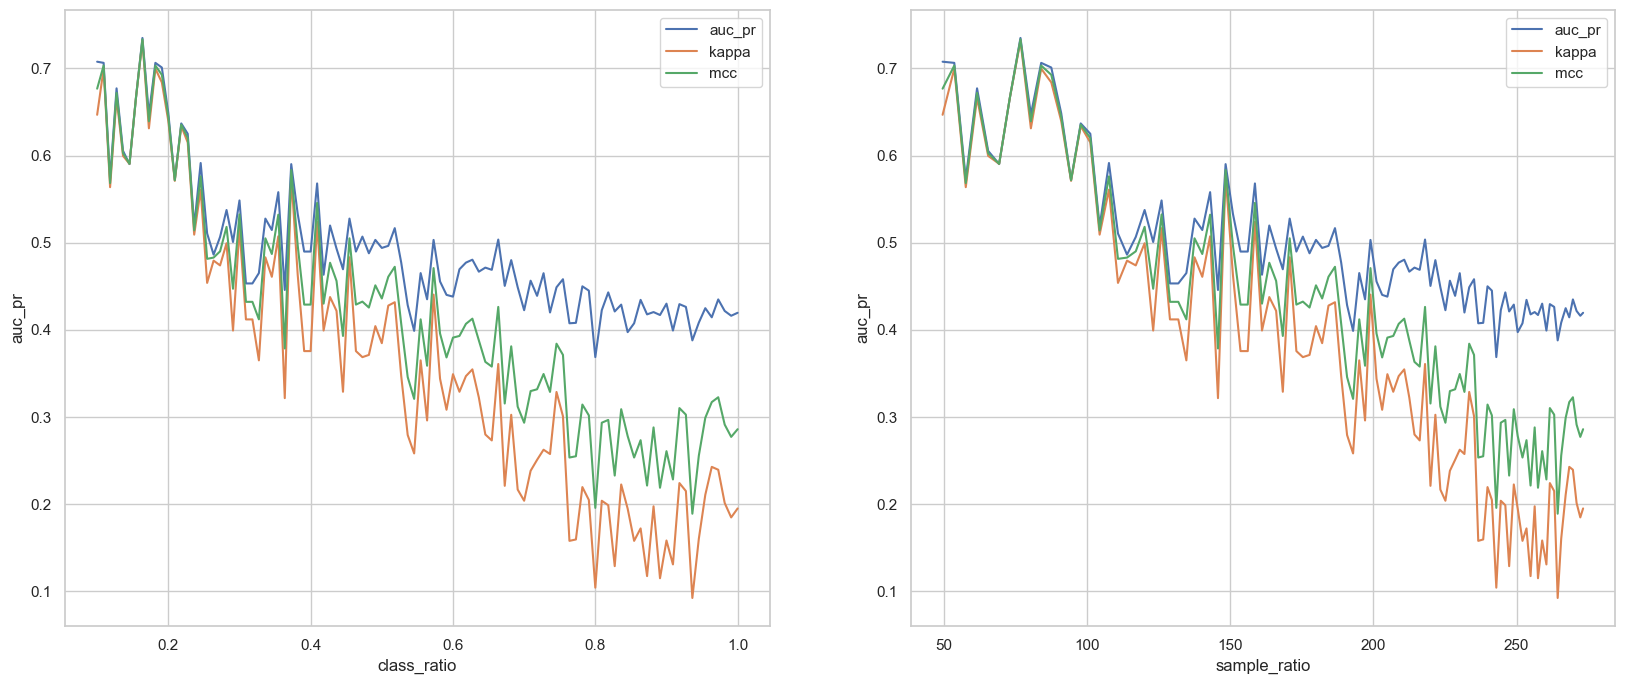

In [265]:
fig, ax = plt.subplots(1, 2, figsize=(20, 8))
sns.lineplot(tmp, x='class_ratio', y='auc_pr', ax=ax[0], label='auc_pr')
sns.lineplot(tmp, x='class_ratio', y='kappa', ax=ax[0], label='kappa')
sns.lineplot(tmp, x='class_ratio', y='mcc', ax=ax[0], label='mcc')
ax[0].legend()
sns.lineplot(tmp, x='sample_ratio', y='auc_pr', ax=ax[1], label='auc_pr')
sns.lineplot(tmp, x='sample_ratio', y='kappa', ax=ax[1], label='kappa')
sns.lineplot(tmp, x='sample_ratio', y='mcc', ax=ax[1], label='mcc')
ax[1].legend()

In [266]:
undersampler = RandomUnderSampler(random_state=0, sampling_strategy=0.1)
X_train_undersmapling, y_train_undersampling = undersampler.fit_resample(X_train, y_train)
boosting = CatBoostClassifier(n_estimators=study.best_params['n_estimators'], learning_rate=study.best_params['learning_rate'], random_seed=0, verbose=0).fit(X_train_undersmapling, y_train_undersampling)
boosting.set_probability_threshold(study.best_params['threshold'])
y_pred = boosting.predict(X_test)
print(f'auc-pr: {auc_pr(y_test, y_pred)}')
print(f'kappa: {kappa(y_test, y_pred)}')
print(f'mcc: {mcc(y_test, y_pred)}')

auc-pr: 0.7077539997425184
kappa: 0.6468662755495298
mcc: 0.6768367190355347


Даже такой наивный подход может дать относительно неплохие результаты и улучшить наши метрики. Тем не менее, сейчас мы никак не используем информацию о распределении объектов в выборке. Оказывается, что даже относительно простые эвристические правила могут заметно поднять нам качество - например, мы можем при отбрасывании использовать близость отдельных объектов мажорного класса к минорному и отбрасывать самые близкие. Протестируйте алгоритм [Near-Miss](https://www.site.uottawa.ca/~nat/Workshop2003/jzhang.pdf) на наших данных и постройте графики, аналогичные предыдущему пункту (также добавьте график с зависимостью качества от числа соседей).

In [ ]:
from imblearn.under_sampling import NearMiss

tmp = defaultdict(list)
for i in tqdm(np.linspace(0.1, 1., 100)):
	tmp['class_ratio'].append(i)
	undersampler = NearMiss(sampling_strategy=i, n_jobs=-1)
	X_train_undersmapling, y_train_undersampling = undersampler.fit_resample(X_train, y_train)
	boosting = CatBoostClassifier(n_estimators=study.best_params['n_estimators'], learning_rate=study.best_params['learning_rate'], random_seed=0, verbose=0).fit(X_train_undersmapling, y_train_undersampling)
	boosting.set_probability_threshold(study.best_params['threshold'])
	y_pred = boosting.predict(X_test)
	tmp['auc_pr'].append(auc_pr(y_test, y_pred))
	tmp['kappa'].append(kappa(y_test, y_pred))
	tmp['mcc'].append(mcc(y_test, y_pred))
	tmp['sample_ratio'].append(y_train.shape[0] / y_train_undersampling.shape[0])

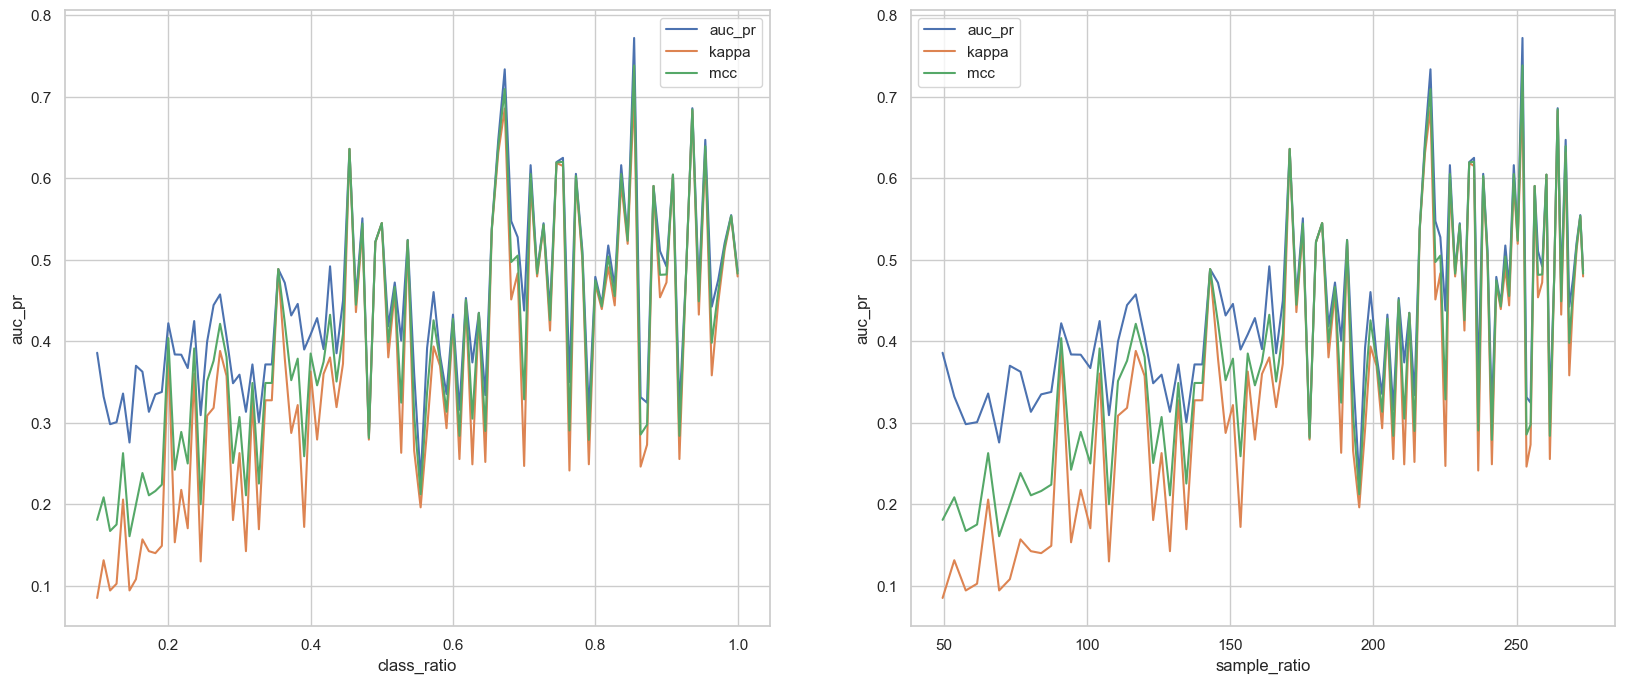

In [268]:
fig, ax = plt.subplots(1, 2, figsize=(20, 8))
sns.lineplot(tmp, x='class_ratio', y='auc_pr', ax=ax[0], label='auc_pr')
sns.lineplot(tmp, x='class_ratio', y='kappa', ax=ax[0], label='kappa')
sns.lineplot(tmp, x='class_ratio', y='mcc', ax=ax[0], label='mcc')
ax[0].legend()
sns.lineplot(tmp, x='sample_ratio', y='auc_pr', ax=ax[1], label='auc_pr')
sns.lineplot(tmp, x='sample_ratio', y='kappa', ax=ax[1], label='kappa')
sns.lineplot(tmp, x='sample_ratio', y='mcc', ax=ax[1], label='mcc')
ax[1].legend()

In [ ]:
tmp1 = defaultdict(list)
for i in tqdm(range(1, 9)):
	tmp1['nn'].append(i)
	undersampler = NearMiss(sampling_strategy=0.85454545, n_neighbors=i, n_jobs=-1)
	X_train_undersmapling, y_train_undersampling = undersampler.fit_resample(X_train, y_train)
	boosting = CatBoostClassifier(n_estimators=study.best_params['n_estimators'], learning_rate=study.best_params['learning_rate'], random_seed=0, verbose=0).fit(X_train_undersmapling, y_train_undersampling)
	boosting.set_probability_threshold(study.best_params['threshold'])
	y_pred = boosting.predict(X_test)
	tmp1['auc_pr'].append(auc_pr(y_test, y_pred))
	tmp1['kappa'].append(kappa(y_test, y_pred))
	tmp1['mcc'].append(mcc(y_test, y_pred))
	tmp1['sample_ratio'].append(y_train.shape[0] / y_train_undersampling.shape[0])

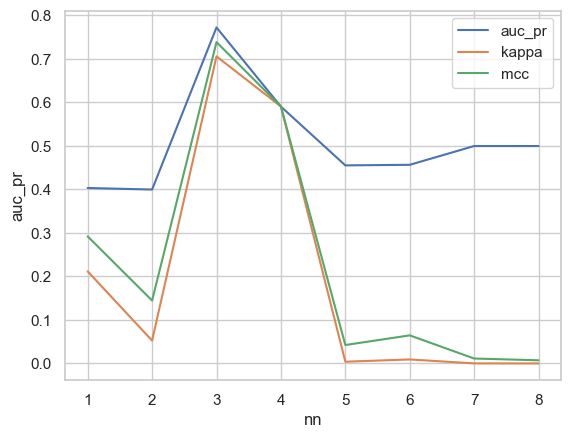

In [271]:
sns.lineplot(tmp1, x='nn', y='auc_pr', label='auc_pr')
sns.lineplot(tmp1, x='nn', y='kappa', label='kappa')
sns.lineplot(tmp1, x='nn', y='mcc', label='mcc')
plt.legend()

In [273]:
undersampler = NearMiss(sampling_strategy=0.85454545, n_neighbors=3, n_jobs=-1)
X_train_undersmapling, y_train_undersampling = undersampler.fit_resample(X_train, y_train)
boosting = CatBoostClassifier(n_estimators=study.best_params['n_estimators'], learning_rate=study.best_params['learning_rate'], random_seed=0, verbose=0).fit(X_train_undersmapling, y_train_undersampling)
boosting.set_probability_threshold(study.best_params['threshold'])
y_pred = boosting.predict(X_test)
print(f'auc-pr: {auc_pr(y_test, y_pred)}')
print(f'kappa: {kappa(y_test, y_pred)}')
print(f'mcc: {mcc(y_test, y_pred)}')

auc-pr: 0.7721303835730997
kappa: 0.7057218962912748
mcc: 0.7384192234036916


ну такое

**Бонус (1 балл)**. imblearn также предлагает много различных методов для андерсэмплинга. Выберите что-нибудь еще из предлагаемого на свой вкус, опишите идею метода и протестируйте его.

Возьмём ClusterCentroids. Работает он следующим образом: мы ему задаём N -- количество объектов мажорного класса, которое нужно оставить (на самом деле соотношение, но из одного другое получить просто); дальше он запускает KMeans (ну или что-то ещё, что находит центры кластеров), где K равно N; ну и после того, как центры найдены, он берёт их в качестве объектов мажорного класса (то есть прошлые объекты удаляются). С одной стороны идея намного умнее рандомного удаления объектов мажорного класса, с другой стороны работает этот undersampling неоправданно долго из-за того, что метод ищет слишком много кластеров.

In [597]:
from imblearn.under_sampling import ClusterCentroids

undersampler = ClusterCentroids(random_state=0, sampling_strategy=0.1)
X_train_clusters, y_train_clusters = undersampler.fit_resample(X_train, y_train)

def objective(trial):
    params = {
        'n_estimators' : trial.suggest_int('n_estimators', 1, 100),
        'learning_rate' : trial.suggest_float('learning_rate', 0, 1)
    }
    threshold = trial.suggest_float('threshold', 0, 1)
    boosting = CatBoostClassifier(**params, random_seed=0, verbose=0).fit(X_train_clusters, y_train_clusters)
    boosting.set_probability_threshold(threshold)
    y_pred = boosting.predict(X_val)
    return auc_pr(y_val, y_pred)

study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=100)
boosting = CatBoostClassifier(n_estimators=study.best_params['n_estimators'], learning_rate=study.best_params['learning_rate'], random_seed=0, verbose=0).fit(X_train_clusters, y_train_clusters)
boosting.set_probability_threshold(study.best_params['threshold'])
y_pred = boosting.predict(X_test)

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
[I 2024-05-03 22:02:31,267] A new study created in memory with name: no-name-cd3d8a00-00d6-4c13-b273-de5817186a56
[I 2024-05-03 22:02:31,449] Trial 0 finished with value: 0.4923926664970919 and parameters: {'n_estimators': 42, 'learning_rate': 0.5064208598318702, 'threshold': 0.1660713086860358}. Best is trial 0 with value: 0.4923926664970919.
[I 2024-05-03 22:02:31,591] Trial 1 finished with value: 0.4744360645377931 and parameters: {'n_estimators': 64, 'learning_rate': 0.8493341577108278, 'threshold': 0.4057926998400674}. Best is trial 0 with value: 0.4923926664970919.
[I 2024-05-03 22:02:31,618] Trial 2 finished with value: 0.42379934823987225 and parameters: {'n_estimators': 7, 'learning_rate': 0.890027452473355, 

In [598]:
print(f'auc-pr: {auc_pr(y_test, y_pred)}')
print(f'kappa: {kappa(y_test, y_pred)}')
print(f'mcc: {mcc(y_test, y_pred)}')

auc-pr: 0.41685977786360495
kappa: 0.3994433237508378
mcc: 0.4076959035004198



**Бонус (2 балла)**. Сможете ли вы с помощью комбинации любых методов оверсэмплинга, андерсэмплинга и классификации набрать 0.8 на всех трех метриках?

Выше есть результат

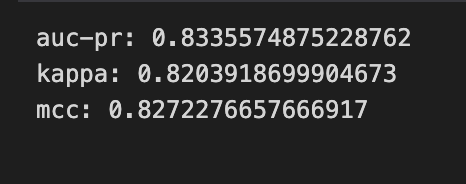

# Часть 2. Поиск аномалий. 

Как вы могли заметить, методы балансировки выборок очень часто могут привести к не самым лучшим результатам из-за того, что они по сути искажают информацию о реальном распределении данных - в реальности обычно требуется долгий подбор в принципе работоспособных для задачи методов и их аккуратная настройка. 

Теперь давайте попробуем слегка сменить постановку задачи и переключиться на задачу "одноклассовой" классификации, то есть - поиска *аномалий* в выборке. В общем-то, это вполне согласуется с нашей областью работы - мы действительно можем назвать мошеннические транзакции аномальньми (как интуитивно, так и на основании наблюдаемой балансировки данных). 

Стоит отметить, что методы обнаружения аномалий чаще всего относятся к классу методов обучения без учителя. Это дает некоторый положительный эффект - нам не обязательно нужно тратить время на разметку данных (тем не менее, для контроля качества какую-то часть разметить все-таки придется). Впрочем, чаще всего перфоманс таких методов оказывается заметно хуже, чем у честного обучения с учителем (если мы можем себе его позволить).



**Задание 4. (3 балла).** На занятиях вы разбирали схожий с Random Forest подход для детекции аномалий без известной разметки данных, называемый Isolation Forest. Напомним суть: на этапе обучения мы создаем ансамбль из решающих деревьев, в котором признак и порог на каждую вершину подбираются случайно. Затем мы считаем для объектов оценку аномальности через длину пути до соответствующего листа в каждом дереве.

В данном задании вам предлагается реализовать модификацию данного алгоритма, известную как Extended Isolation Forest. В ней мы на каждом шаге будем определять не порог для признака, а полноценную случайную гиперплоскость, разбивающую выборку на 2 части. С детальным описанием вы можете ознакомиться [здесь](https://arxiv.org/pdf/1811.02141.pdf).

Ниже приведен шаблон кода. Постарайтесь работать в его рамках (минорные изменения вполне допустимы, главное не переворачивайте всю структуру с ног на голову). 

**NB**: будем считать, что в нашем датасете нет категориальных признаков - можете не заморачиваться с их обработкой (но в общем случае, это будет важно).

**Советы**:
 - Численные признаки лучше предобработать надлежащим образом.
 - Возможно, вам поможет выбрасывание некоторых признаков.
 - Внимательно следите за знаками.
 - Не игнорируйте документирующие строки.
 - Вероятнее всего, вы не сможете приблизиться по качеству к supervised-решениям. Если у вас не получается это сделать (но вы уверены в своей правоте), не стоит тратить слишком много времени на поиск ошибок.



**Бонусы (каждый по 0.5)**:
- Сделайте ваш EIF параллельным (`multiprocessing`, `joblib`). Done ✅


- Добавьте возможность откатиться к дефолтному варианту Isolation Forest. (порассуждайте, как можно реализовать это в данной модели?): банально заменить построение гиперплоскости на выбор рандомного предиката и порога. ✅


In [564]:
import random
from joblib import Parallel, delayed

def c_factor(n):
    """
    Computes average path length for an unsuccessful search in a binary search tree.
    Params:
        n: int - number of data points for BST
    """
    if n == 0:
        return 0
    elif n == 1:
        return 1
    return 2 * H(n - 1) - 2 * (n - 1) / n

def H(n):
    return np.log(n) + 0.5772156649

class Node(object):
    """
    A single node object for each tree. Contains information on height, current data,
    splitting hyperplane and children nodes.
    
    Attributes:
        X: np.array - data available to current node
        size: int - length of available data
        
        depth: int - depth of node

        left: Node - left child
        right: Node - right child

        kind: str - either "internal" or "external", indicates the type of current node

        n: np.array - normal vector for the splitting hyperplane
        p: float - intercept term for the splitting hyperplane
    """
    def __init__(self, X, depth, left, right, kind, n, p):
        """
        Node(h, left, right, kind, w, b)
        Represents the node object.
        
        Params:
            X: np.array - data available to current node
            depth: int - depth of node
            
            left: Node - left child
            right: Node - right child
            
            kind: str - either "internal" or "external", indicates the type of current node
            
            n: np.array - normal vector for the splitting hyperplane
            p: float - intercept term for the splitting hyperplane
            
        """
        self.size = len(X)
        
        self.depth = depth
        
        self.left = left
        self.right = right
        
        self.kind = kind
    
        self.n = n
        self.p = p
    
    def __repr__(self):
        """
        For convenience only.
        """
        return f"Node(size={self.size}, depth={self.depth}, kind={self.kind})"

class RandomizedTree(object):
    """
    Single randomized tree object. Stores root and its depth (tree is built recursively).
    Attributes:
        depth: int - current tree depth
        
        max_depth: int - maximum tree depth
        
        root: Node - root node 

        internal_count: int - number of internal nodes

        external_count: int - number of external nodes
        
    """
    def __init__(self, X, max_depth, vanila_if):
        """
        Single randomized tree object. Stores root and its depth (tree is built recursively).
        Params:
            X: np.array - train sample
            max_depth: int - maximum tree depth

        """
        self.depth = 0
        self.max_depth = max_depth
        self.vanila_if = vanila_if
        
        self.internal_count = 0
        self.external_count = 0

        self.root = self.grow(X, 0)
        
    def __repr__(self):
        """
        For convenience only.
        """
        
        return f"RandomizedTree(depth={self.depth}, max_depth={self.max_depth}, n_internal={self.internal_count}, n_external={self.external_count})"


    def grow(self, X, depth):
        """
        Grow tree in a recursive manner.
        Params:
            X: np.array - available train sample
            
            depth: int - current tree depth
            
        Returns:
            node: Node - a trained node with separating hyperplane data.
                         Node provides access to children if necessary (these are built recursively)
        """
        if depth >= self.max_depth or X.shape[0] <= 1:
            self.depth = max(depth, self.depth)
            self.external_count += 1
            return Node(X, depth, None, None, 'external', None, None)
        
        mask, n, p = self.splitter(self.vanila_if, X)
        self.internal_count += 1
        return Node(X, depth, self.grow(X[mask], depth+1), self.grow(X[~mask], depth+1), 'internal', n, p)

    def score_samples(self, X):
        """
        Calculate anomaly scores for given data. You may utilize outer function `calc_height`.
        Params:
            X: np.array - data to be evaluated
            
        Returns:
            scores: np.array - estimated anomaly scores
        """
        return RandomizedTree.calc_height(X, 0, self.root, self.vanila_if)
    
    @staticmethod
    def calc_height(X, depth, node, vanila_if):
        """
        Calculates anomaly scores for sample in a recursive manner.
        Params:
            X: np.array - current sample, available to node
            
            depth: int - path length up to current node
            
            node: Node - current tree node
            
        Returns:
            scores: int, float or np.array - anomaly scores for sample
        """
        if node.kind == 'external':
            return np.full((X.shape[0], ), node.depth + c_factor(node.size))
        else:
            scores = np.zeros((X.shape[0], ))
            mask = RandomizedTree.splitter(vanila_if, X, node.n, node.p)
            scores[mask] = RandomizedTree.calc_height(X[mask], depth+1, node.left, vanila_if)
            scores[~mask] = RandomizedTree.calc_height(X[~mask], depth+1, node.right, vanila_if)
            return scores
        
    @staticmethod
    def splitter(vanila_if, X, n=None, p=None):
        if vanila_if:
            if n is None:
                # random.seed = 0
                n = random.randint(0, X.shape[1] - 1)
                p = np.random.randn(1).item()
                return X[:, n] <= p, n, p
            else:
                return X[:, n] <= p
        else:
            if n is None:
                # np.random.seed(0)
                n = np.random.randn(X.shape[1])
                p = np.random.uniform(np.min(X, axis=0), np.max(X, axis=0))
                filter = (X - p) @ n <= 0
                return filter, n, p
            else:
                filter = (X - p) @ n <= 0
                return filter

        
    
class ExtendedIsolationForest(object):
    """
    Extended Isolation Forest object. Stores training data and trained randomized trees.
    Attributes:
        n_trees: int - number of Randomized Trees
        
        max_depth: int - maximum depth of each tree
        
        subsample_rate: float - draw `subsample_rate * X.shape[0]` samples for each tree
        
        trees: list - container for trained trees 
        
        contamination: float - estimated fraction of anomaly samples in data. Used for thresholding
        
    """
    
    def __init__(self, n_trees, subsample_rate, max_depth=None, contamination=0.01, vanila_if=False):
        """
        Extended Isolation Forest object. Stores training data and trained randomized trees.
        Params:
            n_trees: int - number of Randomized Trees

            subsample_rate: float - draw `subsample_rate * X.shape[0]` samples for each tree

            max_depth: int or None - maximum depth of each tree. Defaults to ceil(log_2(subsample_size)) if not provided

            contamination: float - estimated fraction of anomaly samples in data. Used for thresholding

            vanila_if: bool - whether to use EIF or IF

        """
        self.n_trees = n_trees
        self.max_depth = max_depth
        self.subsample_rate = subsample_rate
        self.trees = []
        self.contamination = contamination
        self.vanila_if = vanila_if
        self.is_fit = False
        
    def __repr__(self):
        """For convenience only."""
        
        return f"ExtendedIsolationForest(n_trees={self.n_trees}, max_depth={self.max_depth}, subsample_rate={self.subsample_rate}, contamination={self.contamination}, is_fit={self.is_fit})"
        
    def fit(self, X):
        """
        Fit EIF to new data.
        Params:
            X: np.array - 2d array of samples
        """
        self.sample_size = int(self.subsample_rate * X.shape[0])
        if self.max_depth is None:
            self.max_depth = int(np.ceil(np.log2(self.sample_size)))
        random.seed = 0
        idx = random.sample(range(X.shape[0]), self.sample_size)
        self.trees = Parallel(n_jobs=-1)(delayed(RandomizedTree)(X[idx], self.max_depth, self.vanila_if) for _ in range(self.n_trees))
        # for _ in range(self.n_trees):
        #     self.trees.append(RandomizedTree(X[idx], self.max_depth, self.vanila_if))
        self.is_fit = True
        return self
    
    def score_samples(self, X):
        """
        Estimate (normalized) anomaly score for each given sample
        Params:
            X: np.array - new samples

        Returns:
            scores: np.array - anomaly scores (larger value means higher probability of a sample being an outlier)
        """
        sum_h = sum(Parallel(n_jobs=-1)(delayed(tree.score_samples)(X) for tree in self.trees))
        # sum_h = np.zeros((X.shape[0], ))
        # for tree in self.trees:
        #     sum_h += tree.score_samples(X)
        sum_h /= self.n_trees
        return 2 ** (-sum_h / c_factor(self.sample_size))
    
    def get_scores(self, X):
        if not self.is_fit:
            raise ValueError('EIF is not fitted yet')
        scores = self.score_samples(X)
        scores -= np.percentile(scores, 100.0 * self.contamination)
        return scores
    
    def predict(self, X):
        """
        Predict if given samples are outliers.
        Params:
            X: np.array - new samples

        Returns:
            labels: np.array - anomaly labels (1 for outliers, 0 for inliers)
        """
        scores = self.get_scores(X)
        labels = np.zeros_like(scores)
        labels[scores < 0] = 1
        return labels

**Задание 5. (1 балл).** Протестируйте вашу реализацию EIF и подберите оптимальные гиперпараметры (наш метод не использует разметку, поэтому можете попробовать делать это на обучающей выборке). Сравните ее с обычным IF из `sklearn` (желательно делать это на одних и тех же параметрах). Удалось ли сделать лучше?

In [574]:
def eif_objective(trial):
    params = {
        'n_trees': trial.suggest_int('n_trees', 1, 30),
        'subsample_rate': trial.suggest_float('subsample_rate', 0.1, 1, step=0.1),
        'contamination': trial.suggest_float('contamination', 0.01, 0.5, step=0.01)
    }
    eif = ExtendedIsolationForest(**params).fit(X_train.to_numpy())
    y_pred = eif.predict(X_val.to_numpy())
    return auc_pr(y_pred, y_val)

study = optuna.create_study(direction='maximize')
study.optimize(eif_objective, n_trials=10, n_jobs=-1)

[I 2024-05-03 21:13:23,261] A new study created in memory with name: no-name-f6576ab8-93fe-4c99-937c-64e94b3c8353
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/joblib/externals/loky/process_executor.py:700: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(
[I 2024-05-03 21:13:46,288] Trial 3 finished with value: 0.012236227660545627 and parameters: {'n_trees': 3, 'subsample_rate': 0.4, 'contamination': 0.03}. Best is trial 3 with value: 0.012236227660545627.
[I 2024-05-03 21:13:46,310] Trial 5 finished with value: 0.0029142235174326745 and parameters: {'n_trees': 2, 'subsample_rate': 0.9, 'contamination': 0.11}. Best is trial 3 with value: 0.012236227660545627.
[I 2024-05-03 21:13:46,407] Trial 7 finished with value: 0.07452260968698336 and parameters: {'n_trees': 5, 'subsample_rate': 1.0, 'contamination': 0.16}. Best is trial 7 with value: 0.

In [575]:
study.best_params

{'n_trees': 19, 'subsample_rate': 0.6, 'contamination': 0.47000000000000003}

In [577]:
eif = ExtendedIsolationForest(**study.best_params).fit(X_train.to_numpy())
y_pred = eif.predict(X_test.to_numpy())
print(f'auc-pr: {auc_pr(y_test, y_pred)}')
print(f'kappa: {kappa(y_test, y_pred)}')
print(f'mcc: {mcc(y_test, y_pred)}')

auc-pr: 0.2506093364126186
kappa: 0.00011999688623428273
mcc: 0.0020094003439184347


In [497]:
from sklearn.ensemble import IsolationForest

ifor = IsolationForest(n_estimators=study.best_params['n_trees'], contamination=study.best_params['contamination'], random_state=0).fit(X_train.to_numpy())
y_pred = ifor.predict(X_test.to_numpy())
y_pred[y_pred == 1] = 0
y_pred[y_pred == -1] = 1
print(f'auc-pr: {auc_pr(y_test, y_pred)}')
print(f'kappa: {kappa(y_test, y_pred)}')
print(f'mcc: {mcc(y_test, y_pred)}')

auc-pr: 0.5007165190203231
kappa: 0.0013213342990553135
mcc: 0.025711941178554697


Возможно, ваш алгоритм выдал большие оценки объектам с негативной разметкой. Постарайтесь выбрать несколько таких объектов и доступно объяснить (= с кодом и графиками), почему так вышло:

In [512]:
scores = eif.get_scores(X_test.to_numpy())
X_test[y_test == 1][scores[y_test == 1] > 0]

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,V11,V12,V13,V14,V15,V16,V17,V18,V19,V20,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Hour,Day
275992,166831.0,-1.034943,-0.685452,-0.748684,0.767702,-0.007642,0.318102,3.064349,-0.967551,-0.057739,1.225528,1.011075,-0.722601,-1.540522,0.348552,0.325002,-0.490033,-0.970929,0.584207,1.072853,0.043849,-0.428992,0.793054,0.786027,1.249083,-0.273723,-1.249987,1.260338,-0.277644,634.30,22,1
279863,169142.0,-0.984271,0.681674,-2.979933,1.235493,-1.134935,-1.509076,-0.713650,0.583757,-1.879564,-5.131841,2.072864,-5.421763,-1.240989,-6.953076,0.438866,-3.307071,-5.381300,-1.569061,0.480526,1.625280,1.059986,-0.439836,1.023956,-0.486893,1.031126,1.634907,0.725116,0.448275,390.00,22,1
280149,169351.0,-0.345201,0.682106,-1.459981,0.330758,-0.811843,-0.002512,-1.806446,1.013235,-0.593694,-3.181244,1.758547,-2.777244,-0.420940,-4.232410,-0.778548,-1.829401,-5.928547,-0.604886,0.327100,0.321650,1.023557,1.149383,0.305775,0.052952,-1.419005,0.976950,0.954106,0.588827,77.89,23,1
281144,169966.0,-1.589750,0.354788,-3.561235,1.283379,-0.609036,-2.209425,-1.784833,0.886450,-1.485790,-4.817922,1.894287,-5.034494,-1.132810,-6.693792,0.154305,-2.909551,-5.433326,-1.763520,-0.043586,0.397278,0.794088,-0.370964,-0.730404,-0.303245,-0.629546,1.256912,2.192284,-0.768596,245.00,23,1
281674,170348.0,1.016993,0.095970,-1.703833,0.288636,0.834017,-0.072579,0.180302,-0.057256,0.525954,-0.816204,0.481175,0.729487,0.382235,-2.033065,-0.909522,0.592793,1.063846,1.428479,0.729091,-0.022898,-0.223751,-0.406690,-0.115576,-0.743440,0.600960,-0.600582,0.007402,-0.046379,42.53,23,1


Я хз, мб потому что они идут достаточно близко и в те часы, когда транзакций много, а обманов мало

**Задание 6. (1 балл).** `sklearn` также предлагает нам и другие методы для поиска аномалий. В этом задании мы предлагаем вам сделать следующее:

Для начала попробуйте использовать методы Local Outlier Factor и One-Class SVM. Сравните результаты с IF и EIF.  

In [515]:
from sklearn.neighbors import LocalOutlierFactor

lof = LocalOutlierFactor(novelty=True, n_jobs=-1).fit(X_train)
y_pred = lof.predict(X_test)
y_pred[y_pred == 1] = 0
y_pred[y_pred == -1] = 1
print(f'auc-pr: {auc_pr(y_test, y_pred)}')
print(f'kappa: {kappa(y_test, y_pred)}')
print(f'mcc: {mcc(y_test, y_pred)}')

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but LocalOutlierFactor was fitted with feature names
  warnings.warn(


auc-pr: 0.5003862223938766
kappa: 0.0
mcc: nan


/var/folders/n6/f0pmc36s6nbcbbqtyldp_frm0000gn/T/ipykernel_54934/4031012049.py:14: RuntimeWarning: invalid value encountered in scalar divide
  return (tp * tn - fp * fn) / np.sqrt((tp + fp) * (tp + fn) * (tn + fp) * (tn + fn))


In [516]:
from sklearn.svm import OneClassSVM

ocsvm = OneClassSVM().fit(X_train)
y_pred = ocsvm.predict(X_test)
y_pred[y_pred == 1] = 0
y_pred[y_pred == -1] = 1
print(f'auc-pr: {auc_pr(y_test, y_pred)}')
print(f'kappa: {kappa(y_test, y_pred)}')
print(f'mcc: {mcc(y_test, y_pred)}')

auc-pr: 0.5003862223938766
kappa: 0.0
mcc: nan


/var/folders/n6/f0pmc36s6nbcbbqtyldp_frm0000gn/T/ipykernel_54934/4031012049.py:14: RuntimeWarning: invalid value encountered in scalar divide
  return (tp * tn - fp * fn) / np.sqrt((tp + fp) * (tp + fn) * (tn + fp) * (tn + fn))


У вас началась депрессия из-за плохих метрик? Не беда! Сейчас давайте сделаем так: все методы, опробованные в этой части, попробуем задействовать для создания дополнительных признаков в данных. Проделайте это (не забудьте, что обучаться здесь нужно на трейне). Теперь возьмите лучшую модель из предыдущей части и обучите на новых данных. Смогли ли unsupervised-методы повысить вам качество?

In [517]:
smote = SMOTE(random_state=0, sampling_strategy=1/10)
X_train_smote, y_train_smote = smote.fit_resample(X_test, y_test)
def objective(trial):
    params = {
        'n_estimators' : trial.suggest_int('n_estimators', 1, 100),
        'learning_rate' : trial.suggest_float('learning_rate', 0, 1)
    }
    threshold = trial.suggest_float('threshold', 0, 1)
    boosting = CatBoostClassifier(**params, random_seed=0, verbose=0).fit(X_train_smote, y_train_smote)
    boosting.set_probability_threshold(threshold)
    y_pred = boosting.predict(X_val)
    return auc_pr(y_val, y_pred)

study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=100)

[I 2024-05-03 16:01:59,971] A new study created in memory with name: no-name-ff13dc5f-360d-45c7-a462-ea9a8ccf5506
[I 2024-05-03 16:02:00,278] Trial 0 finished with value: 0.7789454763304228 and parameters: {'n_estimators': 43, 'learning_rate': 0.7776220525961411, 'threshold': 0.8670849734567692}. Best is trial 0 with value: 0.7789454763304228.
[I 2024-05-03 16:02:00,358] Trial 1 finished with value: 0.7910309951752013 and parameters: {'n_estimators': 14, 'learning_rate': 0.4887692386289699, 'threshold': 0.8638258209507417}. Best is trial 1 with value: 0.7910309951752013.
[I 2024-05-03 16:02:00,593] Trial 2 finished with value: 0.8236964671462876 and parameters: {'n_estimators': 62, 'learning_rate': 0.7186236271257294, 'threshold': 0.6417261425362478}. Best is trial 2 with value: 0.8236964671462876.
[I 2024-05-03 16:02:00,807] Trial 3 finished with value: 0.7697920382418587 and parameters: {'n_estimators': 54, 'learning_rate': 0.7723862349392417, 'threshold': 0.5697247188285239}. Best i

In [523]:
from sklearn.model_selection import train_test_split
X_train['IF'] = ifor.predict(X_train)
X_train['LOF'] = lof.predict(X_train.drop(columns=['IF']))
X_train['SVM'] = ocsvm.predict(X_train.drop(columns=['IF', 'LOF']))

In [524]:
X_train_last, X_test_last, y_train_last, y_test_last = train_test_split(X_train, y_train, shuffle=False, test_size=0.2, random_state=0)
smote = SMOTE(random_state=0, sampling_strategy=1/10)
X_train_smote, y_train_smote = smote.fit_resample(X_train_last, y_train_last)
boosting = CatBoostClassifier(n_estimators=study.best_params['n_estimators'], learning_rate=study.best_params['learning_rate'], random_seed=0, verbose=0).fit(X_train_smote, y_train_smote)
boosting.set_probability_threshold(study.best_params['threshold'])
y_pred = boosting.predict(X_test_last)
print(f'auc-pr: {auc_pr(y_test_last, y_pred)}')
print(f'kappa: {kappa(y_test_last, y_pred)}')
print(f'mcc: {mcc(y_test_last, y_pred)}')

auc-pr: 0.8073986937028519
kappa: 0.7997931823715699
mcc: 0.8034141513588285


Повысить не смогли, но в целом почти так же получилось, учитывая, что даже с фиксированными сидами тут творится полнейший рандом.

**Бонус. (0.1 балла).**

При сдаче проверяющий запустит следующую клетку один раз. Если она даст положительный результат, вы получите 0.1 бонусных балла. Если она даст отрицательный результат, вы получите -0.1 бонусных балла. 

Если вы хотите отказаться от сдачи данного задания, допишите "хочу" после двоеточия: `your text here`

Ниже вы можете попрактиковаться и оценить ваши силы (изменять код ячейки запрещается!)

In [234]:
import random

rng = random.SystemRandom(0)
rng.uniform(-1.0, 1.0)

-0.5864939224730767